# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: A surprising demonstration of weight initializations
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

##Task
- initialize weights to be normally distributed random numbers
- standar deviation between 0.0001 and 10 in logarithmic steps
- building 10 separate models
- create histogram and plots of acuacy using 80 bins

In [10]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-10-da3f085126c0>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [11]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [12]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [13]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [16]:
def funtion2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [17]:
# note: takes ~6 mins with 25 stdevs

# range of standard deviations to use
stdevs = np.logspace(np.log10(.0001),np.log10(10),25)

# number of histogram bins for plotting distributions
nhistBins = 80

# initialize results output matrix
accresults = np.zeros(len(stdevs))
histodata  = np.zeros((len(stdevs),2,nhistBins))



# Start the timer!
startTime = time.process_time()

# now to really start the experiment
for idx,std in enumerate(stdevs):

  # create the network
  net,lossfun,optimizer = createTheMNISTNet()

  # set all parameters according to the standard deviation
  for p in net.named_parameters():
    p[1].data = torch.randn_like( p[1].data ) * std


  # train the model
  trainAcc,testAcc,losses,net = funtion2trainTheModel(net,lossfun,optimizer)

  # get test accuracy on final 3 runs (averaging increases stability)
  accresults[idx] = np.mean( testAcc[-3:] )

  # collect all parameters into one vector and compute its histogram
  tmpparams = np.array([])
  for p in net.named_parameters():
    tmpparams = np.concatenate( (tmpparams,p[1].data.numpy().flatten()),axis=0 )

  # now compute their histogram
  y,x = np.histogram(tmpparams,nhistBins)
  histodata[idx,0,:] = (x[1:]+x[:-1])/2
  histodata[idx,1,:] = y

  # status report
  timeElapsed = time.process_time() - startTime
  print(f'Finished {idx+1}/{len(stdevs)} after {timeElapsed:3.0f}s. Model accuracy was {accresults[idx]:.2f}%.')

Finished 1/25 after  17s. Model accuracy was 93.63%.
Finished 2/25 after  34s. Model accuracy was 10.98%.
Finished 3/25 after  51s. Model accuracy was 93.77%.
Finished 4/25 after  67s. Model accuracy was 93.92%.
Finished 5/25 after  83s. Model accuracy was 93.55%.
Finished 6/25 after 100s. Model accuracy was 94.42%.
Finished 7/25 after 116s. Model accuracy was 93.25%.
Finished 8/25 after 132s. Model accuracy was 93.57%.
Finished 9/25 after 148s. Model accuracy was 93.45%.
Finished 10/25 after 165s. Model accuracy was 93.80%.
Finished 11/25 after 180s. Model accuracy was 94.33%.
Finished 12/25 after 196s. Model accuracy was 94.95%.
Finished 13/25 after 211s. Model accuracy was 94.68%.
Finished 14/25 after 226s. Model accuracy was 94.82%.
Finished 15/25 after 241s. Model accuracy was 95.30%.
Finished 16/25 after 256s. Model accuracy was 94.95%.
Finished 17/25 after 271s. Model accuracy was 94.82%.
Finished 18/25 after 285s. Model accuracy was 94.72%.
Finished 19/25 after 300s. Model accu

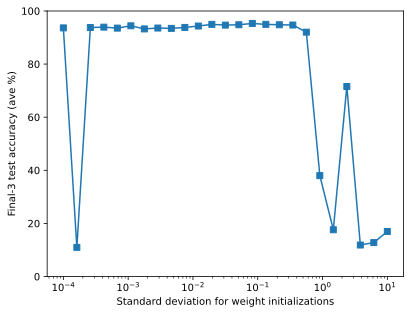

In [20]:
# Show the results!
plt.plot(stdevs,accresults,'s-')
plt.xlabel('Standard deviation for weight initializations')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.xscale('log')
plt.ylim([0,100])
plt.show()

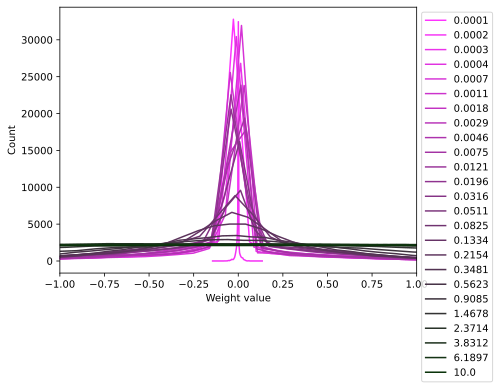

In [21]:
# show the weights distributions

for i in range(len(stdevs)):
  plt.plot(histodata[i,0,:],histodata[i,1,:],color=[1-i/len(stdevs),.2,1-i/len(stdevs)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(stdevs,4),bbox_to_anchor=(1,1),loc='upper left')
plt.xlim([-1,1])
plt.show()